# huh... computer music

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)    

import hcm

samples_dir = './samples'
if not os.path.exists(samples_dir):
    os.makedirs(samples_dir)

Formalism: all audio signals are time series, and furthermore, they are digital. A time series of duration T has N entries, indexed by n: t[n]. 
Time is discretized according to the sampling rate, which is the inverse of the time step $\operatorname{d}t$.  

$ t = [t_{0}, t_{1}, t_{2}, ..., t_{n}, ..., t_{N}]$ 


$ t_{n} = t_{0} + n\,\operatorname{d}t $


$ t_{N} = T$

In [ ]:
# useful functions

# wav_read('filename.wav')
# wav_write('filename.wav', sample_rate, file)
# t = time(t0, T, sample_rate)
# osc = sine(t, f), square(t, f), triangle(t, f)
# VCO(t, f, osc)
# white_noise(t)
# brownian_noise(t)
# lorenz(t, time_scale)
# normalize(signal)
# AM(signal, modulation)
# sample_and_hold(signal, sample_rate, hold)
# scale_constructor(f0, key, num_octaves)
# tempo_to_frequency(tempo, note_duration)

In [2]:
"""
Some useful preliminaries: define duration T, sample rate

TODO: make run/pass args to sample_and_hold
"""

from hcm.signal import time
from hcm.music import notes, keys
from hcm.ts import sample_and_hold 

T = 60;                       # duration (in seconds)
sample_rate = 8000;          # (in samples per second)
t = time(0, T, sample_rate); # time is just np.linspace(0, T, num=sample_rate*T) 

f0 = notes['A4'];            # root note/lowest note in scale
key = keys['Mixolydian'];         # vector whose entries correspond 
num_octaves = 2;             # 



cv = sample_and_hold(t, sample_rate)

TypeError: sample_and_hold() missing 3 required positional arguments: 'signal', 'sample_rate', and 'hold'

## Oscillators

In [4]:
"""
basic three oscillators with fixed frequency
time is a 1-D array, frequency is a scalar
"""

from hcm.signal.osc import *
from hcm.io import wav_write

sine_wave = sine(t, f0)
square_wave = square(t, f0)
triangle_wave = triangle(t, f0)

wav_write( f'{samples_dir}/sine_wave.wav', sample_rate, sine_wave)
wav_write(f'{samples_dir}/square_wave.wav', sample_rate, square_wave)
wav_write(f'{samples_dir}/triangle_wave.wav', sample_rate, triangle_wave)

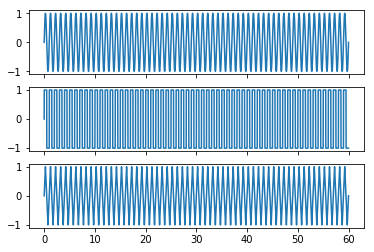

In [5]:
"""
plot basic oscillator waveforms 
"""

f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
ax1.plot(t, sine(t, 1))
ax2.plot(t, square(t, 1))
ax3.plot(t, triangle(t, 1))

But oscillators with fixed frequencies are not so interesting on their own. We might want an oscillator whose frequency we can control by an external signal. In the parlance of modular synthesis, we want a voltage controlled oscillator (VCO). VCO takes three arguments: time, frequency, and oscillator type. Frequency is now an array, so that it can now be a function of time. 

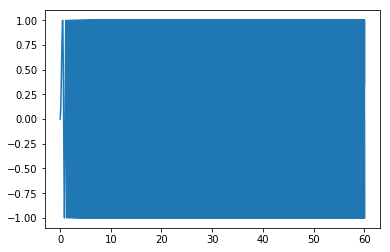

In [6]:
from hcm.signal import VCO

x = VCO(t, t, sine)
plt.plot(t, x)

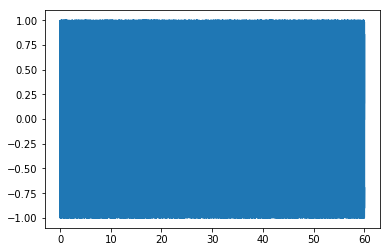

In [7]:

x = VCO(t, f0+sine(t, 1), triangle)
plt.plot(t, x)

wav_write(f'{samples_dir}/VCO.wav', sample_rate, x)

## Noise 

White noise is obtained by sampling random numbers on the interval [-1.0, 1.0] from a random uniform distribution.

In [8]:
from hcm.signal.noise import white_noise

noise = white_noise(t)
wav_write(f'{samples_dir}/white_noise.wav', sample_rate, noise)

Brown noise is obtained by simulating a Brownian motion. Observe that the Brownian motion wanders off from the origin, which is something that needs to be addressed. Perhaps if x exceeds some threshold, it gets reset to 0, or something like that. 

In [9]:
from hcm.signal.noise import brownian_noise

brownian = brownian_noise(t)
wav_write(f'{samples_dir}/brownian_noise.wav', sample_rate, brownian)

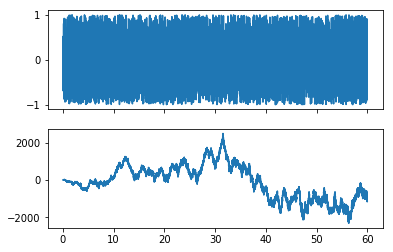

In [10]:
# plot of each of the respective noise signals
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(t[0::100], noise[0::100])
ax2.plot(t, brownian)

## Lorenz system

The exemplar chaotic dynamical system. Three coupled nonlinear ordinary differential equations we can get away integrating by Euler's method because the time steps are very small. 

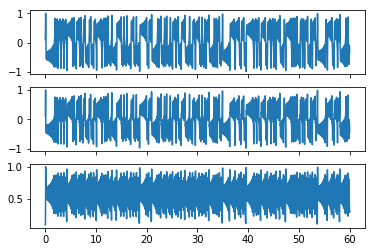

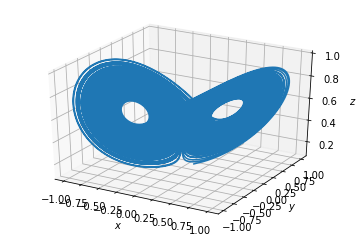

In [11]:
from hcm.dynamical import lorenz

time_scale = 4; # workable values for this fudge factor lie in the range ...
soln = lorenz(t, time_scale)

x = soln[0]
y = soln[1]
z = soln[2]

# plot basic oscillator waveforms 
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
ax1.plot(t, x)
ax2.plot(t, y)
ax3.plot(t, z)


# plot first three variables
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(x, y, z)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')
plt.show()

There are many potential uses for these signals: with the right value of time_scale, they can be heard themselves, although the signals are not particularly pleasant on their own. As modulating signals, they can perform admirably in gating amplitudes of oscillators tuned to musical notes, or making wobbly noises by controlling the frequencies of oscillators. 

More interestingly, the values of each variable can be mapped to positions on a musical scale, and the Lorenz system will spit out pleasant melodies. 

Also notice in the phase plot that there are two distinct basins of attraction. The system switches from one strange attractor to the other whenever x changes sign. This can be used to encode things like chord changes. 

In [ ]:
from hcm.signal import time
from hcm.music import notes, keys
from hcm.music import scale_constructor, tempo_to_frequency, frequency_map
from hcm.ts import sample_and_hold
from hcm.io import add_channels

sample_rate = 8000
T = 60
t = time(0, T, sample_rate)

f0 = notes['C4']
key = keys['Mixolydian']
num_octaves = 2
scale = scale_constructor(f0, key, num_octaves)

time_scale = 4; # workable values for this fudge factor lie in the range ...
soln = lorenz(t, time_scale)

hold = tempo_to_frequency(150, 'eighth')
x = sample_and_hold(soln[0], sample_rate, hold)
y = sample_and_hold(soln[1], sample_rate, hold)
z = sample_and_hold(soln[2], sample_rate, hold)

fx = frequency_map(x, scale)
fy = frequency_map(y, scale)
fz = frequency_map(z, scale)


X = VCO(t, fx, triangle)
Y = VCO(t, fy, triangle)
Z = VCO(t, fz, triangle)

wav_write('test_lorenz_6.wav', sample_rate, add_channels((X,Y,Z)))

In [ ]:
"""
TODO: comment/test notebook from here down. 
"""

In [ ]:
CV = normalize(sample_and_hold(brownian_noise(t), sample_rate, 5))
freq = frequency_map(scale, CV)
x = VCO(t, freq, sine)
wav_write('test.wav', sample_rate, x)

In [99]:
x = soln[0]
y = soln[1]
z = soln[2]

fx = frequency_map(x, scale)
fy = frequency_map(y, scale)
fz = frequency_map(z, scale)


X = VCO(t, fx, triangle)
Y = VCO(t, fy, triangle)
Z = VCO(t, fz, triangle)

wav_write('test_lorenz_5.wav', sample_rate, add_channels((X,Y,Z)))

In [134]:
XAM = AM(x, X)
YAM = AM(y, Y)
ZAM = AM(z, Z)

wav_write('test_lorenz2.wav', sample_rate, (XAM+YAM+ZAM)/3)

In [97]:
soln = lorenz(t, 1)

x = sample_and_hold(soln[0], sample_rate, sample_rate)
y = sample_and_hold(soln[1], sample_rate, sample_rate)
z = sample_and_hold(soln[2], sample_rate, sample_rate)

fx = frequency_map(scale, x)
fy = frequency_map(scale, y)
fz = frequency_map(scale, z)

X = VCO(t, fx, triangle)
Y = VCO(t, fy, triangle)
Z = VCO(t, fz, triangle)


G = AM(x, triangle(t, notes['G4'])) 
E = AM(y, triangle(t, notes['E4']))
Bb = AM(z, triangle(t, notes['Bb4']))

wav_write('samples/test_lorenz.wav', sample_rate, add_channels((X+Y+Z, G+E+Bb)))

ValueError: A value in x_new is above the interpolation range.

In [92]:
interp = interp1d([-1.0, 1.0], [0, len(scale)-1])

int(interp(min(x)))

0

In [98]:
frequency_map(signal, scale)

array([ 0.10737657,  0.10744368,  0.10751108, ...,  0.49702754,
        0.49753276,  0.49803831])

In [187]:
np.random.rand(1)

array([ 0.34613465])

In [207]:
sample_rate = 8000
T = 60
t = time(0, T, sample_rate)

f0 = notes['C4']
key = keys['Chromatic']
scale = scale_constructor(f0, key, 2)

signal = np.zeros(len(t))

N = 4
for i in range(N):
    note_duration = np.random.choice(['whole', 'half', 'quarter', 'eighth', 'sixteenth'])
    hold = tempo_to_frequency(150, note_duration)
    CV = sample_and_hold(white_noise(t), sample_rate, hold)
    freq = frequency_map(scale, CV)
    x = VCO(t, freq, sine)
    signal = signal + x

signal = normalize(signal)

wav_write('test.wav', sample_rate, signal)

In [203]:
note_duration = np.random.choice(['whole', 'half', 'quarter', 'eighth', 'sixteenth'])

'eighth'

In [212]:
sample_rate = 8000
T = 60
t = time(0, T, sample_rate)

tempo = 120

f0 = notes['C4']
key = keys['Pentatonic']
scale = scale_constructor(f0, key, 2)

signal = np.zeros(len(t))

N = 6
for i in range(N):
    note_duration = np.random.choice(['whole', 'half', 'quarter', 'eighth', 'sixteenth'])
    hold = tempo_to_frequency(tempo, note_duration)
    CV = sample_and_hold(white_noise(t), sample_rate, hold)
    freq = frequency_map(scale, CV)
    x = VCO(t, freq, sine)
    signal = signal + x

signal = normalize(signal)

wav_write('test.wav', sample_rate, signal)

In [107]:
def oscillator(time, frequency, phase, amplitude, waveform):
    """
    amplitude, time, frequency, phase all arrays of equal length
    """
    # initialize signal
    N = len(time);
    x = np.zeros(N);
    # waveforms
    def sine_wave(t, f, phi): 
        return np.sin(2*np.pi*f*t + phi)
    def square_wave(t, f, phi):
        return np.sign(np.sin(2*np.pi*f*t + phi))
    def triangle_wave(t, f, phi):
        return (2/np.pi)*np.arcsin(np.sin(2*np.pi*f*t + phi))
    # populate the signal vector 
    for n in range(0, N):
        x[n] = waveform(time[n], frequency[n], phase[n])
    return x

In [108]:
sample_rate = 8000
T = 30
N = sample_rate*T
t = time(0, T, sample_rate)
phi = np.zeros(N)
A = np.ones(N)
f = 440*np.ones(N)

x = oscillator(t, f, phi, A, sine_wave)

TypeError: 'numpy.ndarray' object is not callable

In [5]:
ohyeah = wav_read('oh_yeah.wav')[0:55000]

In [11]:
ohno = sample_and_hold(ohyeah, 44100, 22050)

In [12]:
wav_write('oh_no.wav', 44100, ohno)

In [15]:
sample_rate = 8000
t = time(0, 10, sample_rate)
wav_write('test.wav', 8000, sample_and_hold(sine(t, 440), sample_rate, 100))